In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import importlib
warnings.filterwarnings('ignore')

In [2]:
import analysis.data.dataframe_creation as dataframe_creation
importlib.reload(dataframe_creation)
from analysis.data.dataframe_creation import pipeline
sd = "2014-01-01"
ed = "2024-01-01"
dataset = pipeline(sd, ed)

[*********************100%***********************]  1 of 1 completed


Total number of tickers 502


[*********************100%***********************]  502 of 502 completed

5 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['SW', 'GEV', 'SOLV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2014-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1388552400, endDate = 1704085200")')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2014-01-01 -> 2024-01-01)')



The following tickers had more than 20% of NaN values, therefore they're removed:
{'SW', 'BF.B', 'SOLV', 'DELL', 'BRK.B', 'MRNA', 'VST', 'CRWD', 'CARR', 'UBER', 'HWM', 'GEHC', 'OTIS', 'GEV', 'CTVA', 'LW', 'KVUE', 'FOX', 'ABNB', 'DAY', 'FTV', 'VICI', 'VLTO', 'IR', 'CEG', 'DOW', 'INVH', 'PLTR', 'FOXA'}

Null values: False
NaN values: False

Creating features


Removing stocks that have more than one NaN column


The dataset has 432 assets
The dataset has 24 predictors:
Ticker
Yavg_return
Yavg_volatility
mkt_corr
1Y_momentum
Davg_span
Davg_volume
Davg_Kurtosis
Davg_Skewness
D_eVaR
D_eCVaR
Sharpe_ratio
totalEsg
environmentScore
socialScore
governanceScore
industry
beta
ROA
ROE
est_ROI
profitMargins
P/B
earningsGrowth
forwardPE


Dataset creation finished



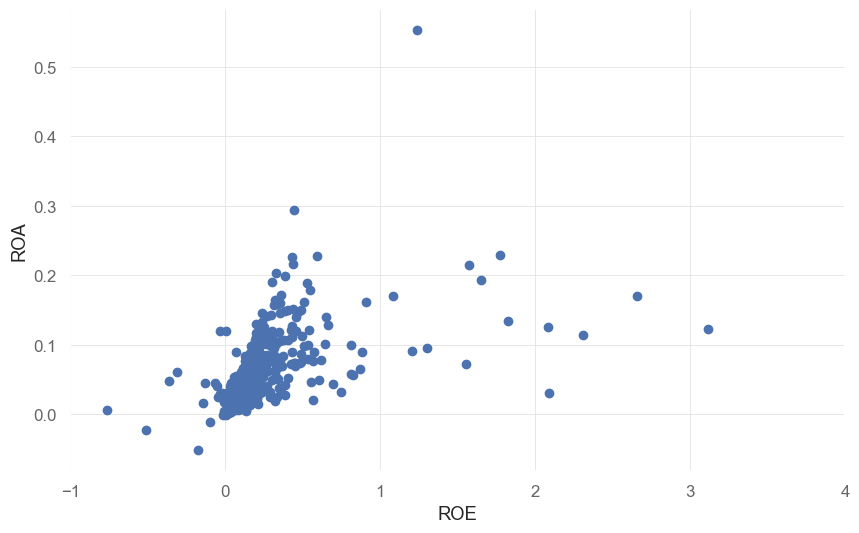

In [6]:
plt.scatter(dataset["ROE"], dataset["ROA"])
plt.xlabel("ROE")
plt.ylabel("ROA")
plt.xlim(-1, 4)
plt.show()

In [7]:
outliers = outliers = dataset[
    (dataset["ROE"] > 0.4)]["Ticker"].unique()
final_dataframe = dataset[~dataset["Ticker"].isin(outliers)]
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,mkt_corr,1Y_momentum,Davg_span,Davg_volume,Davg_Kurtosis,Davg_Skewness,D_eVaR,...,governanceScore,industry,beta,ROA,ROE,est_ROI,profitMargins,P/B,earningsGrowth,forwardPE
3,ABT,0.152782,0.234091,0.669697,1.778593,1.266991,6.174167e+06,6.860902,-0.205403,-0.023649,...,6.56,Health Care,0.722,0.06488,0.14840,0.025887,0.13992,5.575749,0.146,22.552586
4,ACGL,0.169788,0.259333,0.608846,17.683401,0.672525,1.657923e+06,16.083008,-0.341138,-0.026197,...,8.78,Insurance,0.613,0.04861,0.30441,0.161951,0.33859,1.626131,0.362,10.433155
5,ACN,0.193459,0.241761,0.793303,32.828520,3.150631,2.295803e+06,6.974782,0.192867,-0.024283,...,4.01,Technology,1.245,0.11627,0.26675,0.030172,0.11194,8.508687,0.236,27.623913
6,ADBE,0.283202,0.321215,0.707114,76.728479,6.782078,2.951869e+06,8.496982,-0.183421,-0.032159,...,5.14,Technology,1.299,0.15969,0.35355,0.028148,0.25588,13.383815,0.233,18.973000
7,ADI,0.208127,0.304479,0.725294,23.393878,2.254139,2.888632e+06,7.432051,-0.008476,-0.030723,...,5.46,Semiconductors,1.078,0.02860,0.04658,0.015749,0.17068,2.989545,-0.546,23.719196


In [8]:
stock_data_clustering = final_dataframe[["ROE",	"ROA", "est_ROI"]]

stock_data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 3 to 471
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ROE      366 non-null    float64
 1   ROA      365 non-null    float64
 2   est_ROI  366 non-null    float64
dtypes: float64(3)
memory usage: 11.4 KB


In [13]:
from sklearn.preprocessing import MinMaxScaler
for attr in stock_data_clustering.columns:
    scaler = MinMaxScaler()
    stock_data_clustering[attr] = scaler.fit_transform(stock_data_clustering[attr].values.reshape(-1, 1)).flatten()
stock_data_clustering = stock_data_clustering.fillna(0)

In [14]:
from analysis.clustering.kmeans_clustering import run_kmeans
clusters = range(2, 20)
runs = 60
meanDistortions, sil_score, inertias = run_kmeans(clusters, stock_data_clustering, runs)

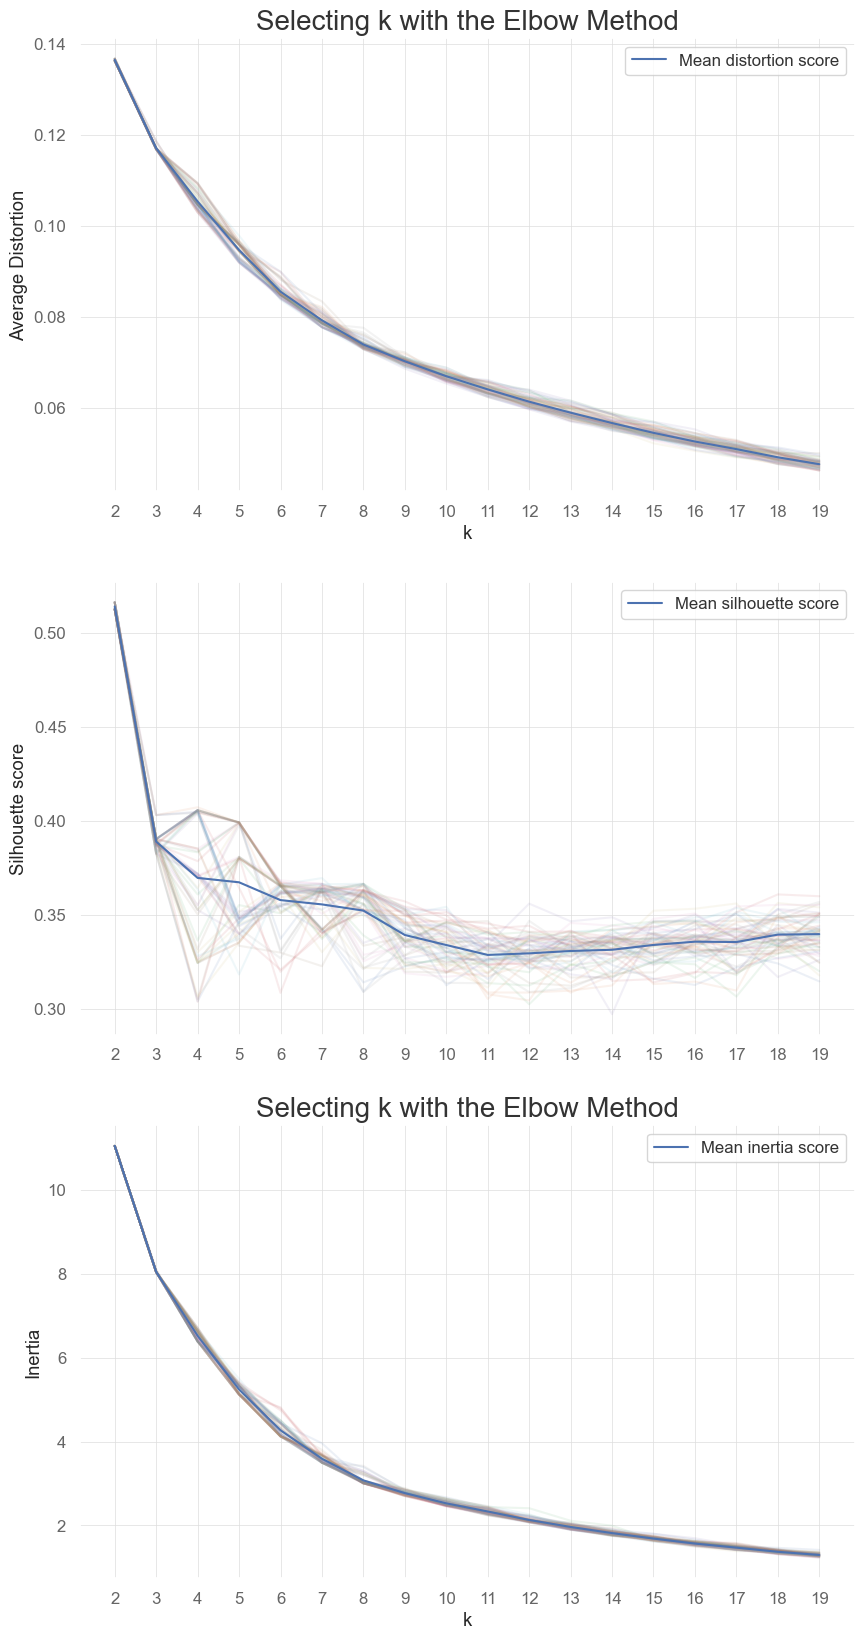

In [8]:
from analysis.data.plotting import plot_kmeans
plot_kmeans(runs, clusters, meanDistortions, sil_score, inertias)

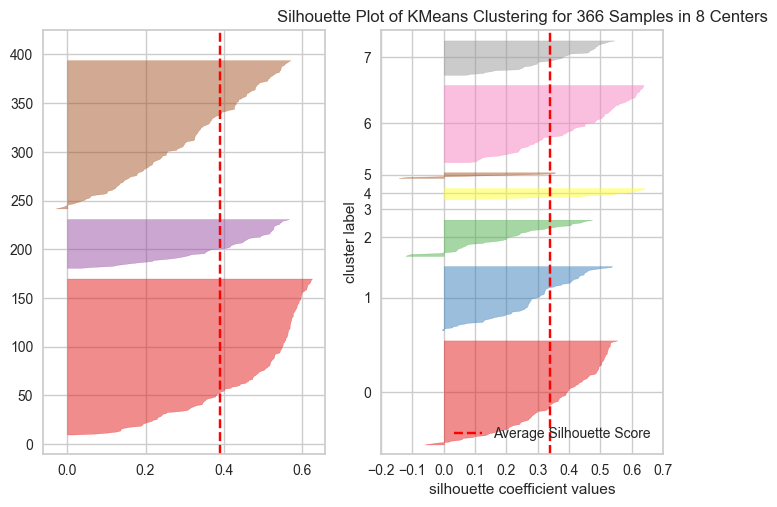

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 366 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [15]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
plt.subplot(1,2,1)
n1 = 4
visualizer = SilhouetteVisualizer(KMeans(n1, random_state=np.argmax(sil_score[n1-1])))
visualizer.fit(stock_data_clustering)
plt.subplot(1,2,2)
n2 = 8
visualizer = SilhouetteVisualizer(KMeans(n2, random_state=np.argmax(sil_score[n2-1])))

visualizer.fit(stock_data_clustering)

visualizer.show()

In [16]:
N_SECTORS = 4
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=N_SECTORS, random_state=np.argmax(sil_score[N_SECTORS-1]))
kmeans.fit(stock_data_clustering)
final_dataframe["Sector"] = kmeans.labels_
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,mkt_corr,1Y_momentum,Davg_span,Davg_volume,Davg_Kurtosis,Davg_Skewness,D_eVaR,...,industry,beta,ROA,ROE,est_ROI,profitMargins,P/B,earningsGrowth,forwardPE,Sector
3,ABT,0.152782,0.234091,0.669697,1.778593,1.266991,6.174167e+06,6.860902,-0.205403,-0.023649,...,Health Care,0.722,0.06488,0.14840,0.025887,0.13992,5.575749,0.146,22.552586,2
4,ACGL,0.169788,0.259333,0.608846,17.683401,0.672525,1.657923e+06,16.083008,-0.341138,-0.026197,...,Insurance,0.613,0.04861,0.30441,0.161951,0.33859,1.626131,0.362,10.433155,2
5,ACN,0.193459,0.241761,0.793303,32.828520,3.150631,2.295803e+06,6.974782,0.192867,-0.024283,...,Technology,1.245,0.11627,0.26675,0.030172,0.11194,8.508687,0.236,27.623913,1
6,ADBE,0.283202,0.321215,0.707114,76.728479,6.782078,2.951869e+06,8.496982,-0.183421,-0.032159,...,Technology,1.299,0.15969,0.35355,0.028148,0.25588,13.383815,0.233,18.973000,1
7,ADI,0.208127,0.304479,0.725294,23.393878,2.254139,2.888632e+06,7.432051,-0.008476,-0.030723,...,Semiconductors,1.078,0.02860,0.04658,0.015749,0.17068,2.989545,-0.546,23.719196,0


In [17]:
cluster_profile = final_dataframe.groupby("Sector").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = final_dataframe.groupby("Sector")["Ticker"].count().values
cluster_profile["Sharpe_ratio"] = (cluster_profile["Yavg_return"]-0.02)/cluster_profile["Yavg_volatility"]

max_cols = ["beta", "D_eSkewness", "Yavg_return", "Sharpe_ratio", "Davg_volume", "ROE", "ROA", "est_ROI", "profitMargins", "earningsGrowth"]
min_cols = ["beta", "Davg_span", "D_eCurtosis", "Yavg_volatility", "D_eVaR", "D_eCVaR", 
            "totalEsg", "environmentScore", "socialScore", "governanceScore"]

# Custom function for styling
def highlight_extremes(val, col_name):
    max_color = "background-color: green"
    min_color = "background-color: blue"
    
    if col_name in max_cols and val == cluster_profile[col_name].max():
        return max_color
    elif col_name in min_cols and val == cluster_profile[col_name].min():
        return min_color
    return ""

cluster_profile.style.apply(lambda x: [highlight_extremes(v, x.name) for v in x], axis=0)
# cluster_profile.style.highlight_max(color="green", axis=0, subset=["beta", "D_eSkewness",	"Yavg_return", "Sharpe_ratio", "Davg_volume"])
# cluster_profile.style.highlight_min(color="green", axis=0, subset=["beta", "Davg_span", "D_eCurtosis",	"Yavg_volatility", "D_eVaR", "D_eCVaR", "totalEsg",	"environmentScore",	"socialScore",	"governanceScore"])

,Yavg_return,Yavg_volatility,mkt_corr,1Y_momentum,Davg_span,Davg_volume,Davg_Kurtosis,Davg_Skewness,D_eVaR,D_eCVaR,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,beta,ROA,ROE,est_ROI,profitMargins,P/B,earningsGrowth,forwardPE,Count
Sector,,,,,,,,,,,,,,,,,,,,,,,,
0,0.135876,0.297383,0.579779,7.547482,1.662150,5270249.696215,17.624712,-0.029515,-0.030274,-0.047680,0.389651,20.760994,5.496149,9.157516,6.106708,0.986621,0.025915,0.064479,0.032946,0.108862,2.629188,0.464257,22.788538,161
1,0.219956,0.323499,0.605840,37.845005,4.148424,5405009.091392,12.928285,0.114995,-0.032647,-0.049671,0.618103,21.007451,6.354314,8.842157,5.810980,1.111627,0.123256,0.264394,0.044530,0.204281,7.615276,0.200765,23.365278,51
2,0.162310,0.307190,0.580680,17.087864,2.384668,5053980.530817,13.183138,-0.067564,-0.031186,-0.048828,0.463264,21.321373,6.615556,9.379085,5.327320,1.051072,0.061365,0.205148,0.054096,0.134997,5.908082,0.157014,19.298493,153
3,0.000185,0.299835,0.503764,-25.304947,0.974248,6307975.715421,6.747106,-0.386187,-0.031067,-0.050196,-0.066086,15.570000,1.920000,8.480000,5.160000,0.669000,0.005900,-0.759690,-0.972140,-0.058490,0.850360,nan,6.944538,1


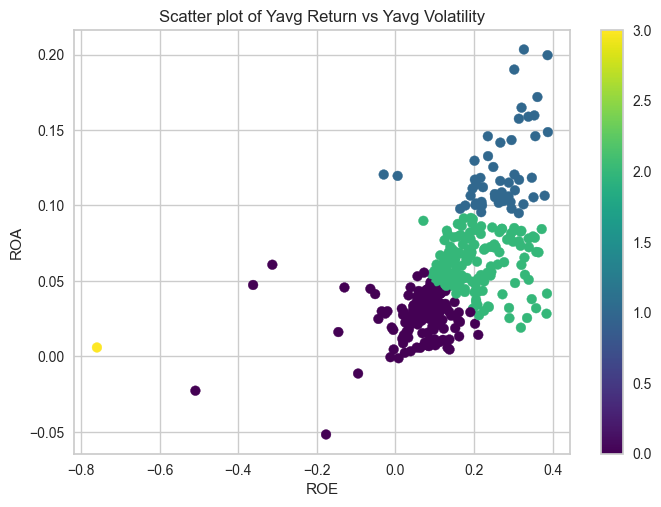

In [22]:
plt.scatter(
    final_dataframe["ROE"], 
    final_dataframe["ROA"], 
    c=final_dataframe["Sector"],  # Use c for color mapping
    cmap='viridis',  # Optional: Choose a colormap
    
)

# Add labels and title
plt.xlabel("ROE")
plt.ylabel("ROA")
plt.title("Scatter plot of Yavg Return vs Yavg Volatility")
plt.colorbar()
# Show the plot
plt.show()

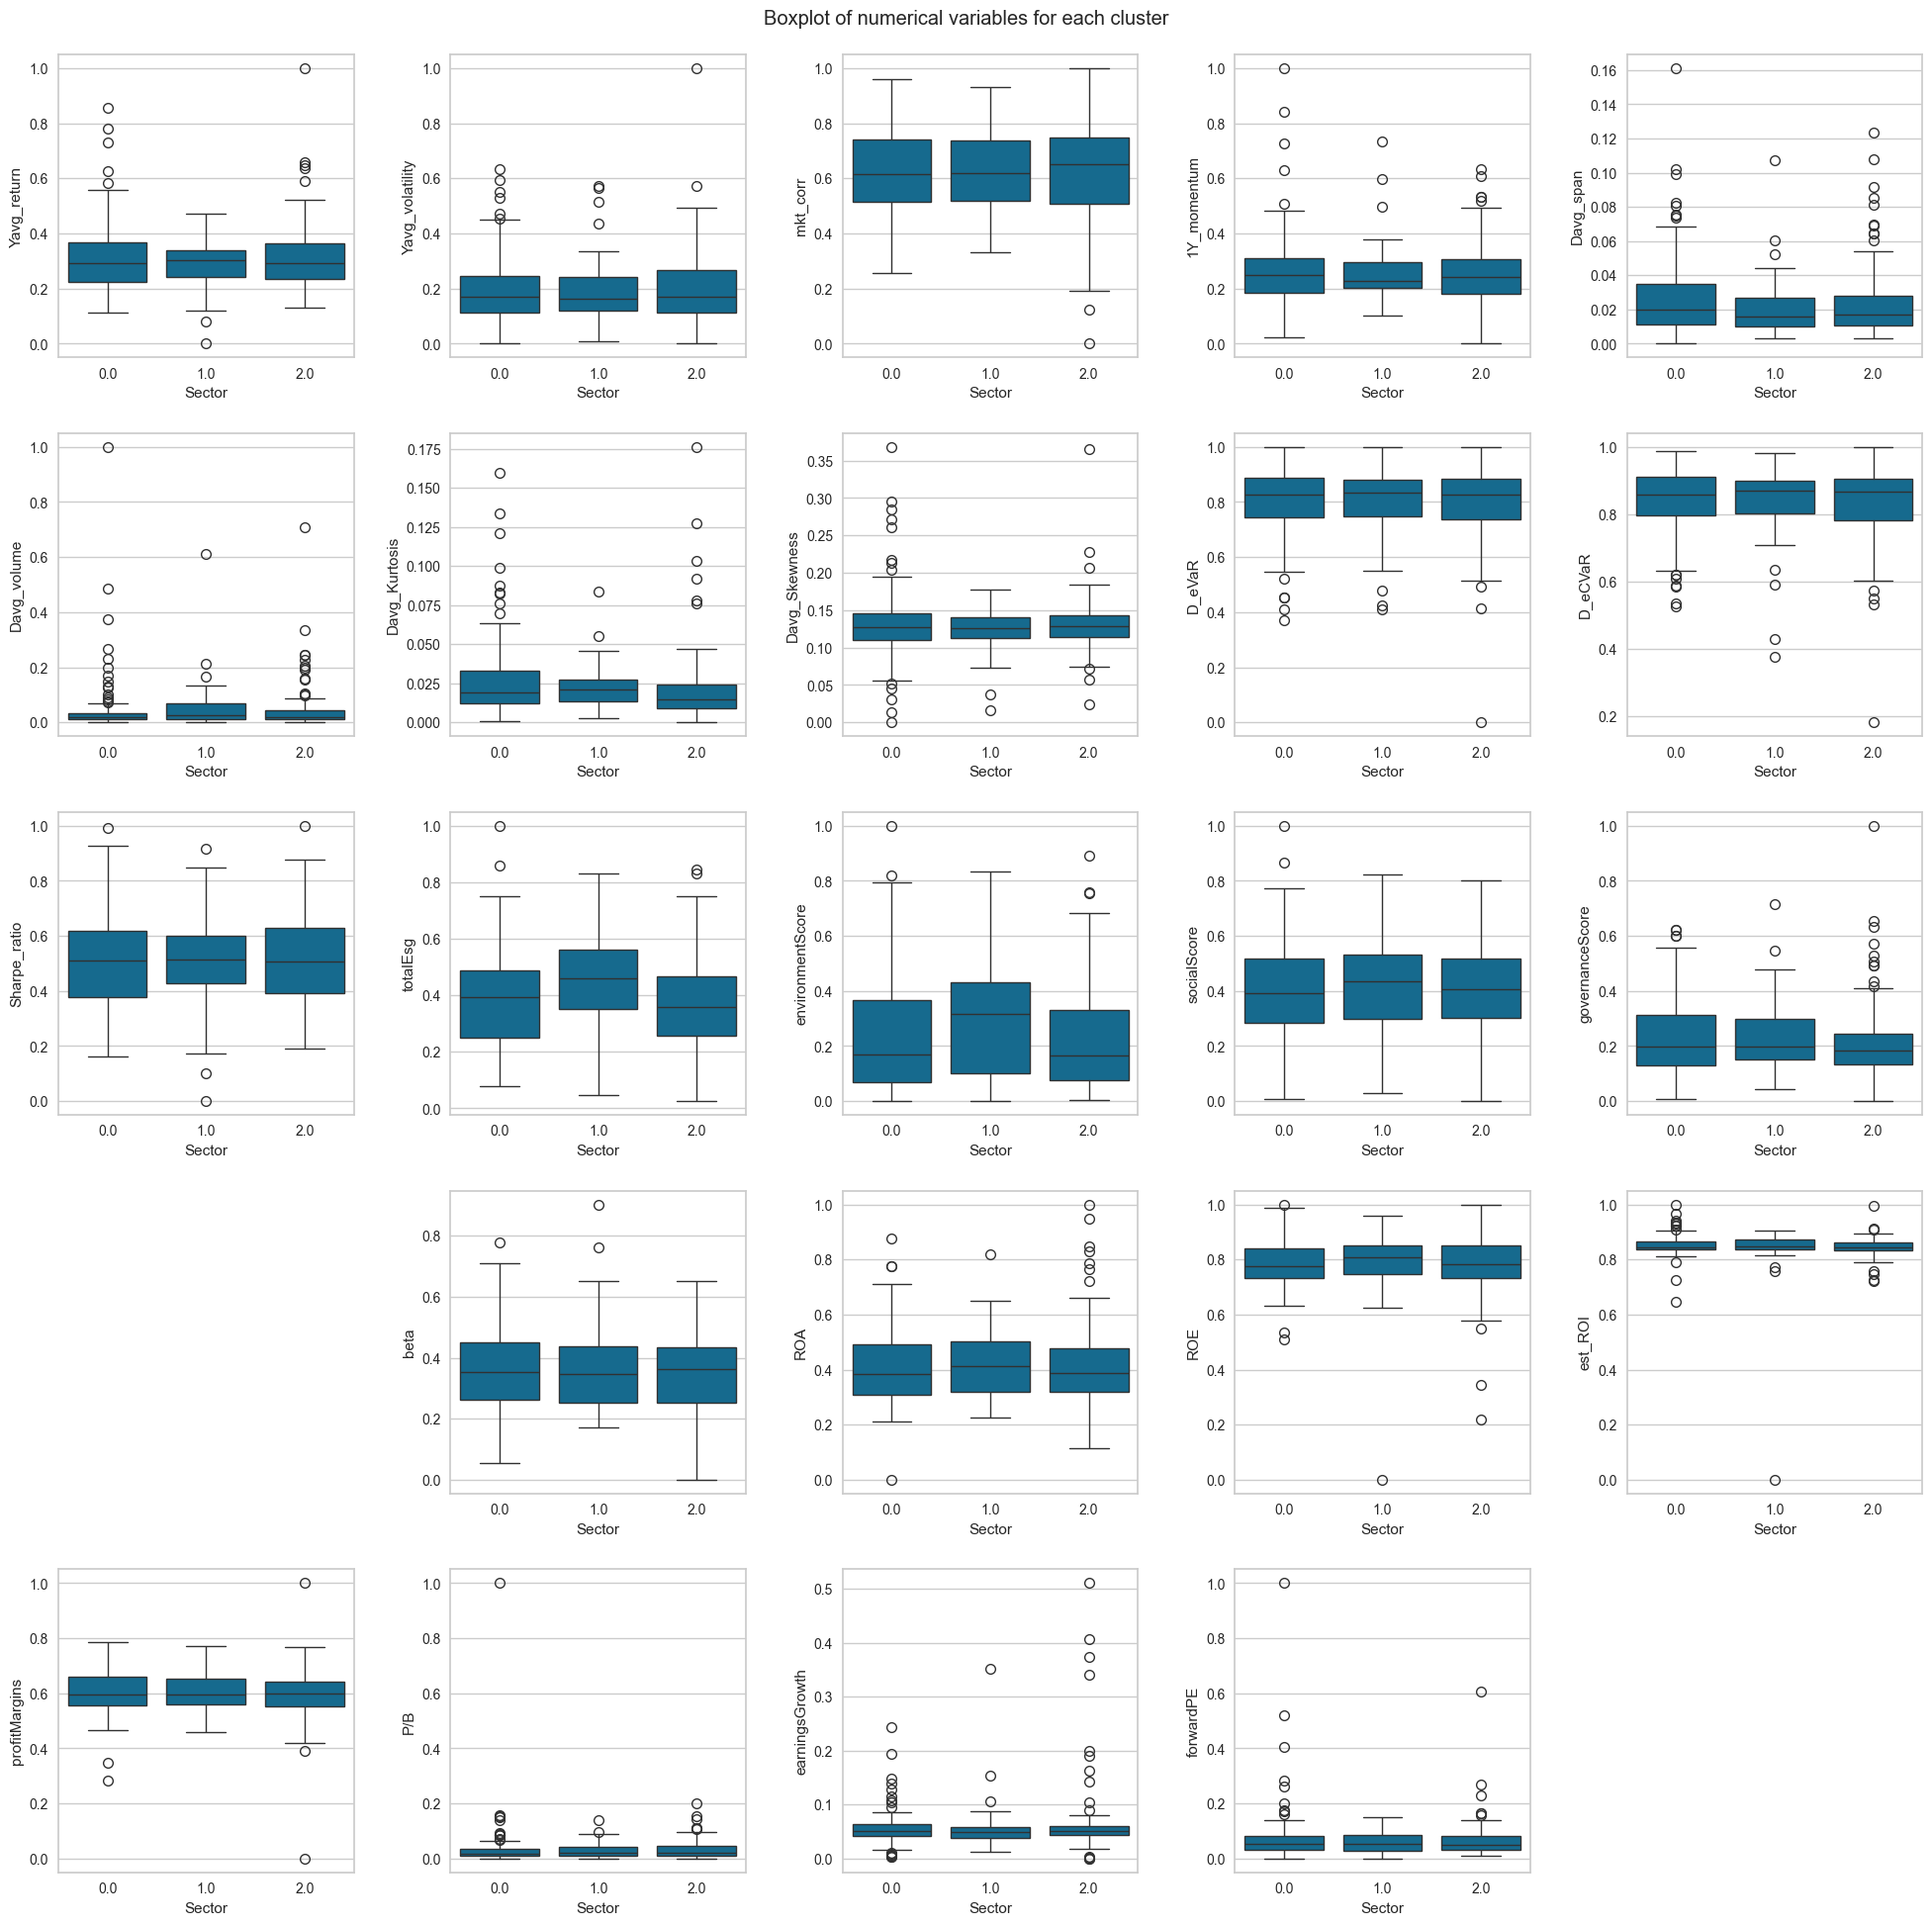

In [23]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaled_data = pd.DataFrame()
for attr in final_dataframe.select_dtypes(include=["float64", "int64"]).columns:
    scaler = MinMaxScaler()
    scaled_data[attr] = scaler.fit_transform(final_dataframe[attr].values.reshape(-1, 1)).flatten()
scaled_data["Sector"] = final_dataframe["Sector"]
plt.figure(figsize=(20, 20))
import seaborn as sns
plt.suptitle("Boxplot of numerical variables for each cluster")
i = 1
for i, variable in enumerate(final_dataframe):
  if variable not in ["Ticker", "industry", "Sector"]:
    plt.subplot(5, 5, i)
    sns.boxplot(data=scaled_data, x="Sector", y=variable)
    i += 1

plt.tight_layout(pad=2.0)

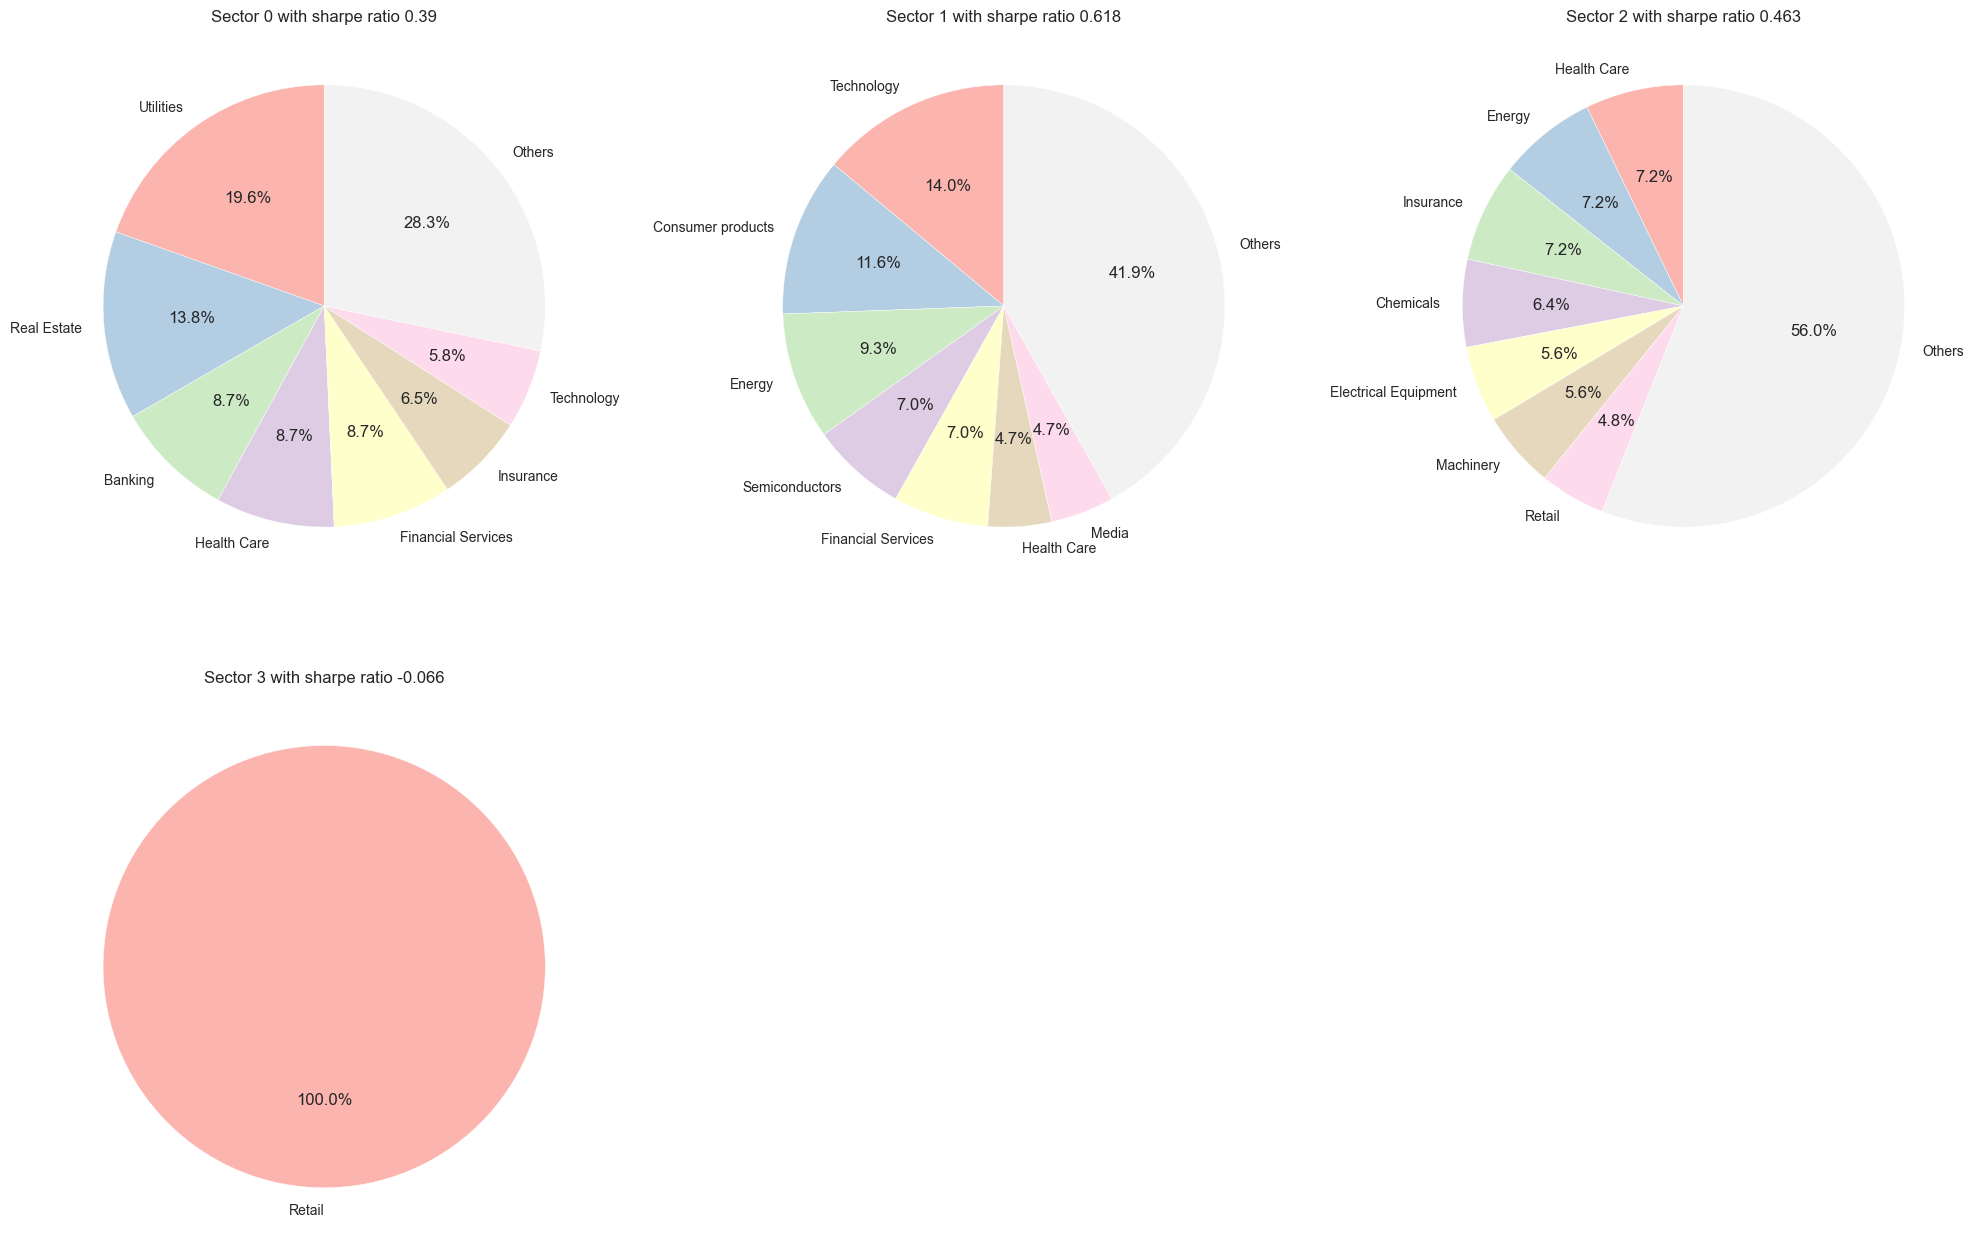

In [24]:
MAX_LABELS = 7
from analysis.data.plotting import plot_cluster_industry
plot_cluster_industry(MAX_LABELS, final_dataframe, cluster_profile)


In [25]:
from analysis.data.dataframe_creation import create_portfolio_clustered
portfolio_ret, asset_ret = create_portfolio_clustered(sd, ed, final_dataframe, list(final_dataframe["Ticker"]), w = "uniform")


[*********************100%***********************]  366 of 366 completed


Null values: False
Null values: False
Cluster Portfolios uniformly built among assets


In [26]:
benchmark = yf.download(tickers="SPY", start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


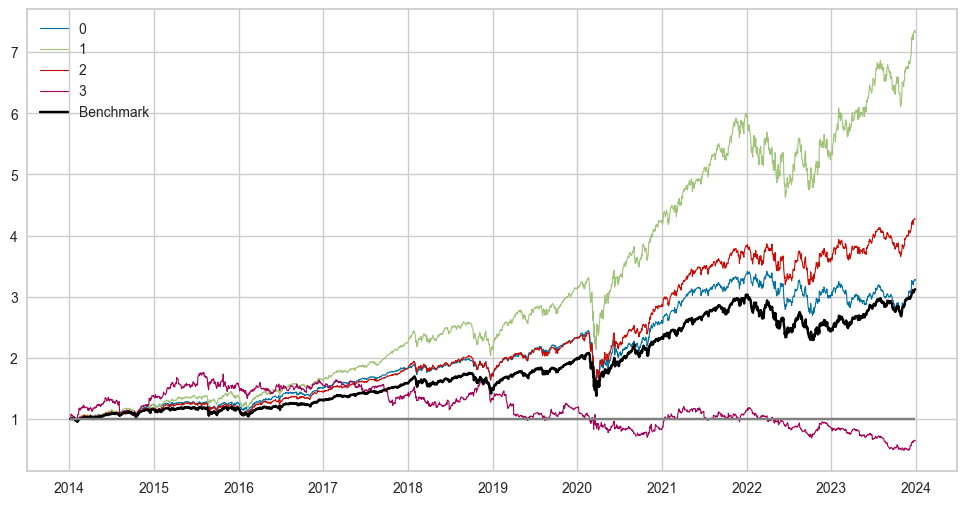

In [27]:
import analysis.data.plotting as plotting
importlib.reload(plotting)
from analysis.data.plotting import portfolio_evolution_time
portfolio_evolution_time(portfolio_ret.reset_index(), benchmark.reset_index())

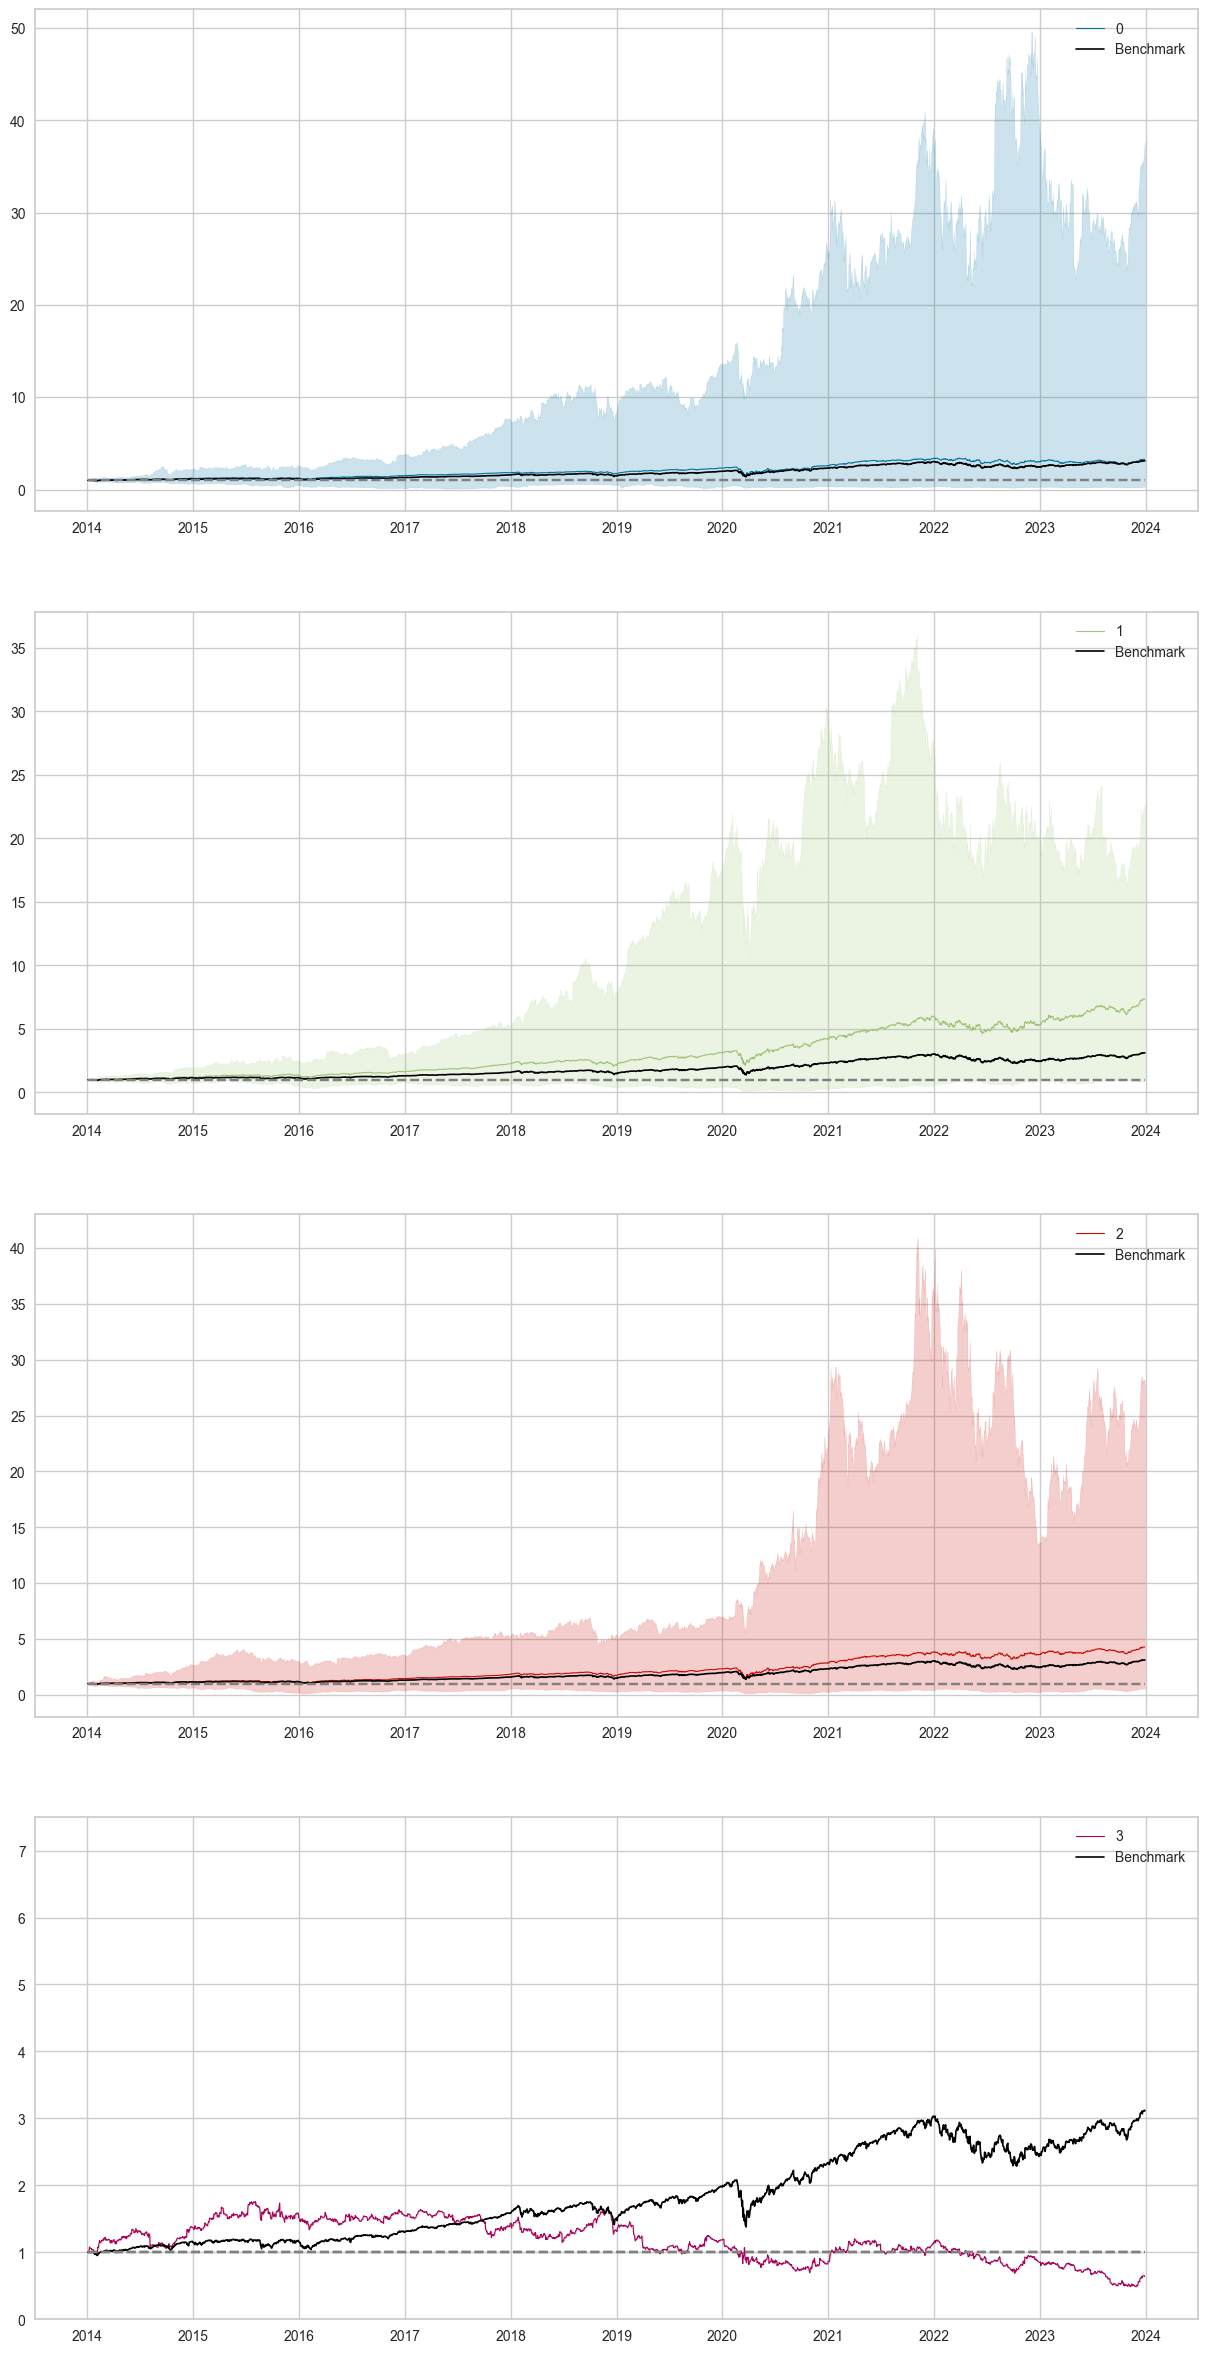

In [28]:
from analysis.data.plotting import portfolio_span
portfolio_span(asset_ret, portfolio_ret, final_dataframe, benchmark, N_SECTORS)

In [29]:
from analysis.data.dataframe_creation import create_portfolio_clustered
sd_test = ed
ed_test = "2025-01-10"
portfolio_ret_t, asset_ret_t = create_portfolio_clustered(sd_test, ed_test, final_dataframe,
                                                           list(final_dataframe["Ticker"]), w="sharpe")

[*********************100%***********************]  366 of 366 completed


Null values: False
Null values: False
Cluster Portfolios based on sharpe ratio


In [30]:
benchmark_t = yf.download(tickers="SPY", start=sd_test, end=ed_test, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2024-01-03  2024-01-03
End Period                 2025-01-08  2025-01-08
Risk-Free Rate             2.0%        2.0%
Time in Market             100.0%      100.0%

Cumulative Return          14.12%      26.32%
CAGR﹪                     13.87%      25.84%

Sharpe                     0.97        1.73
Prob. Sharpe Ratio         78.97%      93.75%
Smart Sharpe               0.93        1.66
Sortino                    1.38        2.5
Smart Sortino              1.32        2.4
Sortino/√2                 0.97        1.77
Smart Sortino/√2           0.93        1.7
Omega                      1.17        1.17

Max Drawdown               -7.2%       -8.41%
Longest DD Days            102         64
Volatility (ann.)          12.17%      12.58%
R^2                        0.78        0.78
Information Ratio          -0.1        -0.1
Calmar                     1.93        3.07

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-12-02,2025-01-02,2025-01-08,37,-7.199640,-7.081235
2,2024-04-01,2024-04-19,2024-07-12,102,-6.229520,-6.087524
3,2024-07-17,2024-08-05,2024-08-19,33,-5.346717,-5.255385
4,2024-09-03,2024-09-06,2024-09-16,13,-3.693062,-2.607043
5,2024-10-21,2024-10-31,2024-11-06,16,-2.628287,-2.545070


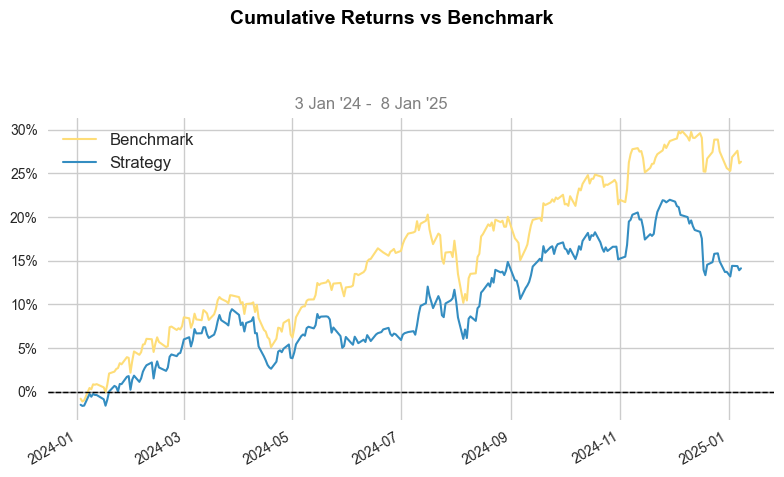

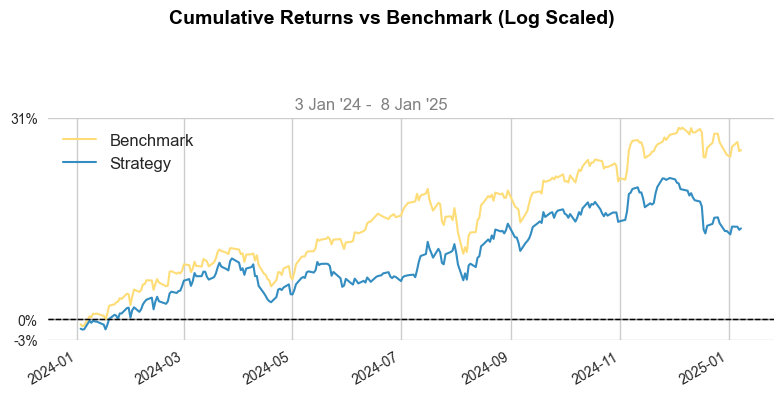

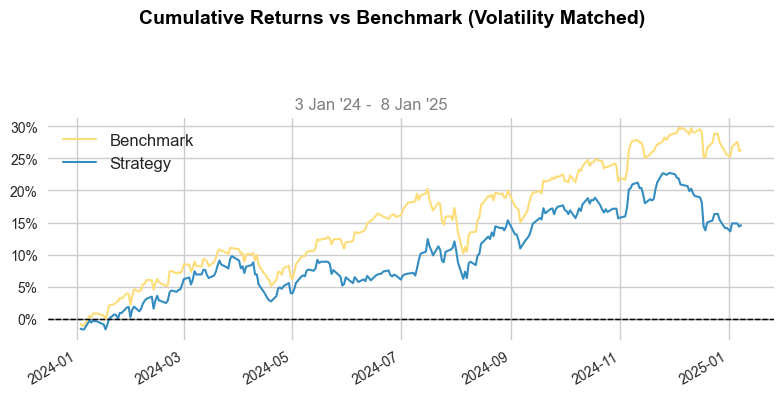

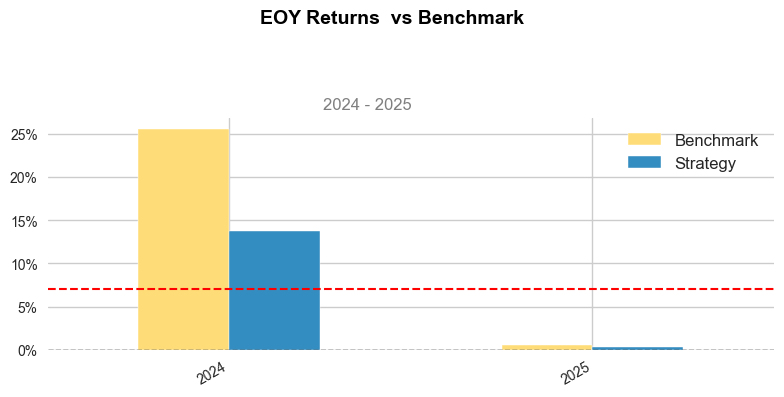

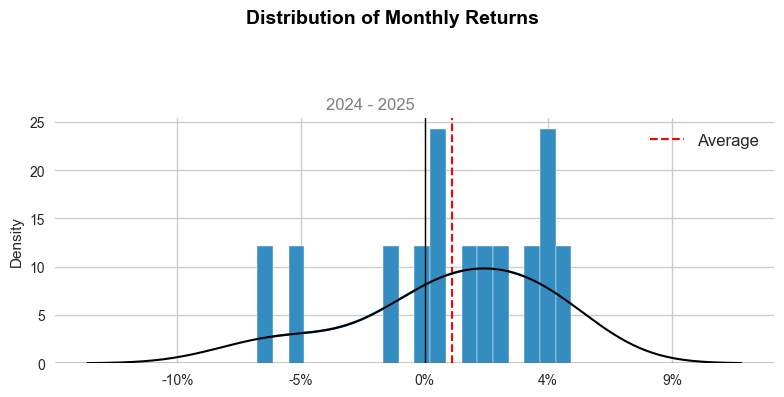

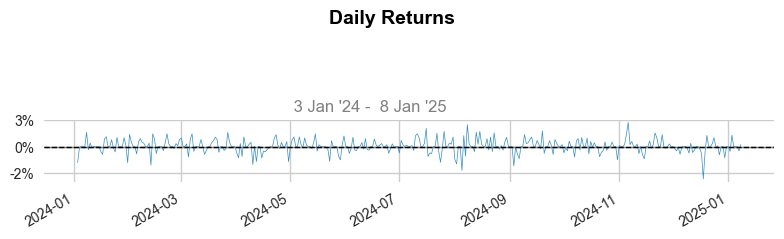

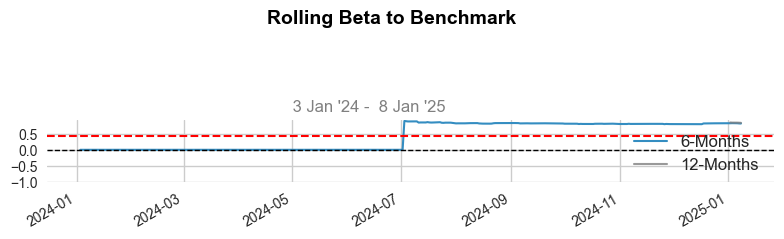

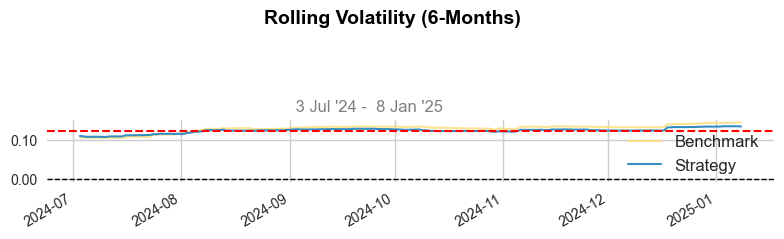

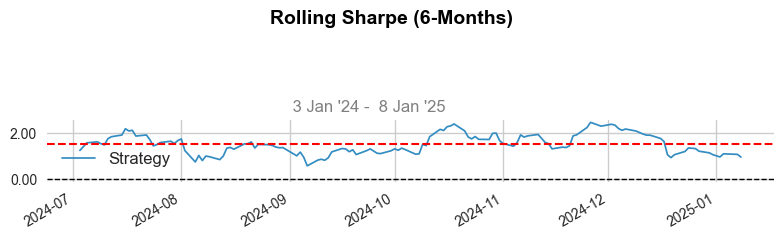

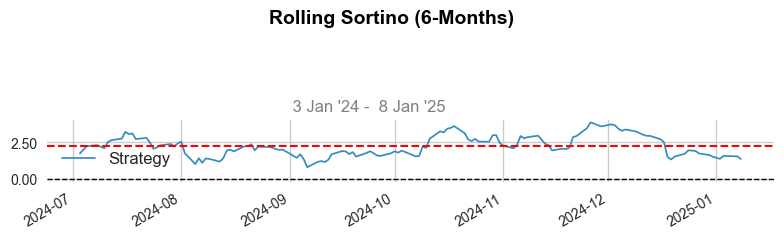

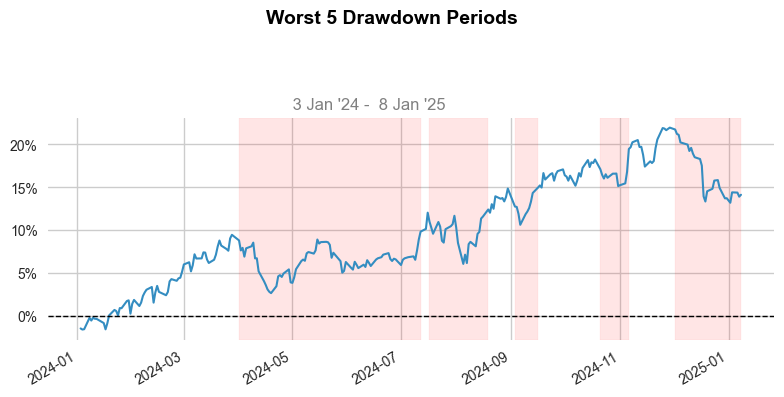

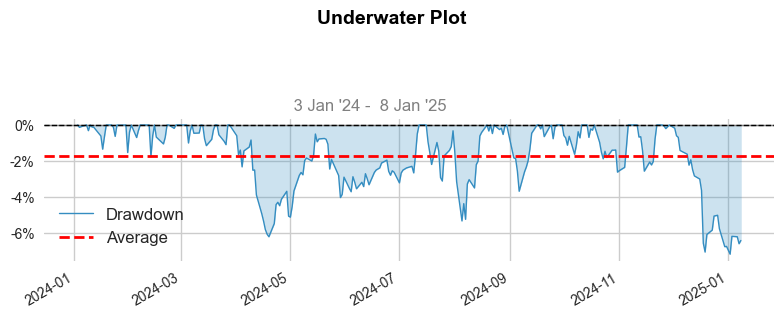

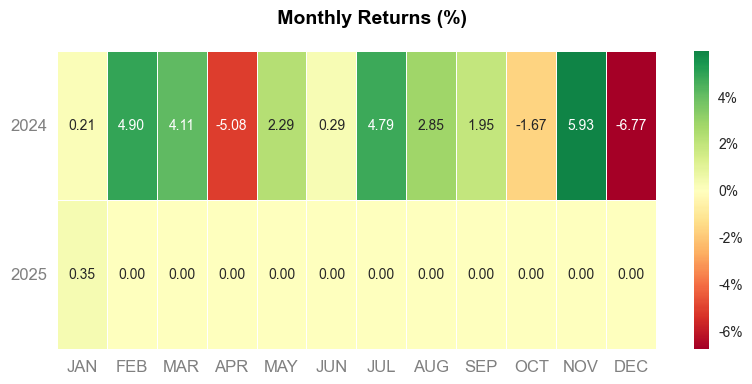

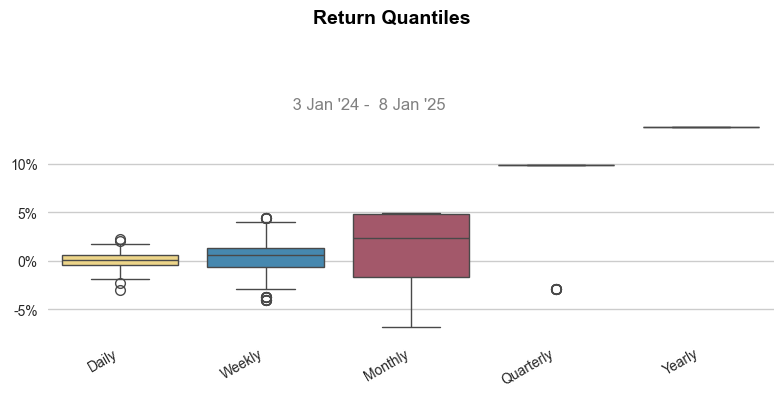

In [31]:
import quantstats as qs
def weights(ratios, cluster, pow, thresh):
    w = np.array(ratios["Sharpe_ratio"] > thresh)*ratios["Sharpe_ratio"]
    ratios["weights"] = np.power(w, pow)
    ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
    return ratios.loc[ratios["Sector"] == cluster, "weights"]

returns = np.zeros(len(portfolio_ret_t))
cp = cluster_profile.reset_index()
for i in portfolio_ret_t.columns:
        weight = weights(cp[["Sector", "Sharpe_ratio"]], i, 1, 0.25).values[0]
        returns += weight*portfolio_ret_t[i] 
        
portfolio_performance = pd.DataFrame(returns).reset_index()
portfolio_performance["Date"] = pd.to_datetime(portfolio_performance["Date"])
portfolio_performance.set_index("Date", inplace=True)
portfolio_performance.columns = ["Returns"]

qs.reports.full(
    portfolio_performance["Returns"],
    benchmark=benchmark_t.pct_change().dropna(),
    rf=0.02,
)

In [49]:
print(qs.__version__)

0.0.64


In [34]:

print("Pandas Version:", pd.__version__)
print("Quantstats Version:", qs.__version__)

Pandas Version: 1.5.3
Quantstats Version: 0.0.64
